In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
SEED = 42

from scipy import stats

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Download and load data

path = kagglehub.dataset_download("mfarhaannazirkhan/heart-dataset")
print("Path to dataset files:", path)
print("Downloading dataset from Kaggle...")
print("Dataset downloaded successfully at:", path)

df = pd.read_csv(f"{path}/cleaned_merged_heart_dataset.csv")
print("\nDataset shape:", df.shape)
print(df.head())

100%|██████████| 27.2k/27.2k [00:00<00:00, 4.62MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mfarhaannazirkhan/heart-dataset/versions/2
Dataset downloaded successfully at: /root/.cache/kagglehub/datasets/mfarhaannazirkhan/heart-dataset/versions/2

Dataset shape: (1888, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalachh  exang  oldpeak  \
0   63    1   3       145   233    1        0       150      0      2.3   
1   37    1   2       130   250    0        1       187      0      3.5   
2   41    0   1       130   204    0        0       172      0      1.4   
3   56    1   1       120   236    0        1       178      0      0.8   
4   57    0   0       120   354    0        1       163      1      0.6   

   slope  ca  thal  target  
0      0   0     1       1  
1      0   0     2       1  
2      2   0     2       1  
3      2   0     2       1  
4      2   0     2       1  


In [ ]:
print(df.columns.tolist())


['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


In [ ]:


# Define feature types based on dataset description
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'target']
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']

# Print any missing values before filling
missing = df.isnull().sum()
print("Missing values before imputation:\n", missing[missing > 0])

# Fill missing values appropriately
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in categorical:
            df[col].fillna(df[col].mode()[0], inplace=True)
        elif col in numerical:
            df[col].fillna(df[col].median(), inplace=True)

# Confirm all missing values have been handled
print("\nMissing values after imputation:\n", df.isnull().sum().sum())

# Label encode categorical features (skip if already numeric)
le = LabelEncoder()
for col in categorical:
    if df[col].dtype == 'object' or df[col].nunique() < 10:  # safe check for categorical
        df[col] = le.fit_transform(df[col])


Missing values before imputation:
 Series([], dtype: int64)

Missing values after imputation:
 0


In [ ]:
# Safely get only numerical columns still present in df
numerical_present = [col for col in numerical if col in df.columns]

# Now perform Z-score based outlier removal
z_scores = np.abs(stats.zscore(df[numerical_present]))
threshold = 3.0
df = df[(z_scores < threshold).all(axis=1)]

print("\nShape after Z-score outlier removal:", df.shape)



Shape after Z-score outlier removal: (1809, 14)


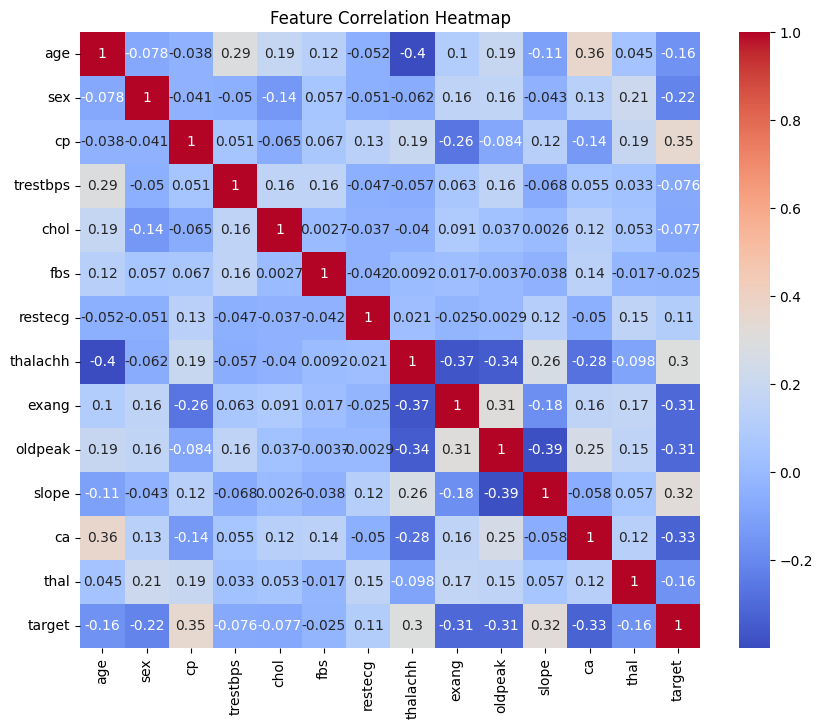

Highly correlated features to drop: []


In [ ]:
# Correlation heatmap & drop highly correlated features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
print("Highly correlated features to drop:", to_drop)
df.drop(columns=to_drop, inplace=True, errors='ignore')

In [ ]:
# Feature selection using correlation with target
corr_target = df.corr()['target'].sort_values(ascending=False)
print("\nCorrelation with target:\n", corr_target)
selected_features = corr_target[abs(corr_target) > 0.1].index.tolist()
if 'target' not in selected_features:
    selected_features.append('target')
df = df[selected_features]
print("\nSelected features:", selected_features)
print("DF shape after selecting features:", df.shape)



Correlation with target:
 target      1.000000
cp          0.353840
slope       0.317166
thalachh    0.298173
restecg     0.108227
fbs        -0.024683
trestbps   -0.076135
chol       -0.076606
age        -0.161627
thal       -0.162134
sex        -0.218419
exang      -0.306831
oldpeak    -0.310088
ca         -0.327166
Name: target, dtype: float64

Selected features: ['target', 'cp', 'slope', 'thalachh', 'restecg', 'age', 'thal', 'sex', 'exang', 'oldpeak', 'ca']
DF shape after selecting features: (1809, 11)


In [ ]:
# Train-test split & scaling
X = df.drop('target', axis=1)
y = df['target']

# Define numeric and categorical columns
num_cols = ['age', 'thalachh', 'oldpeak', 'ca']
cat_cols = ['cp', 'slope', 'restecg', 'thal', 'sex', 'exang']

# Initialize scaler
scaler = StandardScaler()

# Scale only numeric features
X[num_cols] = scaler.fit_transform(X[num_cols])

# Proceed with split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)


In [ ]:
# Hyperparameter tuning - Random Forest (RandomizedSearchCV)
rf = RandomForestClassifier(random_state=SEED)

rf_param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 6, 10, 15, 20],
    'min_samples_split': [2, 4, 6, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    rf, rf_param_dist, n_iter=30, cv=5, scoring='roc_auc', n_jobs=-1, random_state=SEED, verbose=1
)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
print("\nBest RF params:", rf_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best RF params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'bootstrap': False}


In [ ]:
# Hyperparameter tuning - XGBoost (small search)
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=SEED)

xgb_param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb, xgb_param_dist, n_iter=20, cv=5, scoring='roc_auc', n_jobs=-1, random_state=SEED, verbose=1
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("\nBest XGB params:", xgb_search.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best XGB params: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [ ]:
# Train logistic regression (baseline & for ensemble)
lr = LogisticRegression(max_iter=2000, random_state=SEED)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=42)


===== Logistic Regression =====
Accuracy: 0.7818
ROC-AUC: 0.8454
Confusion Matrix:
 [[128  46]
 [ 33 155]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.76       174
           1       0.77      0.82      0.80       188

    accuracy                           0.78       362
   macro avg       0.78      0.78      0.78       362
weighted avg       0.78      0.78      0.78       362



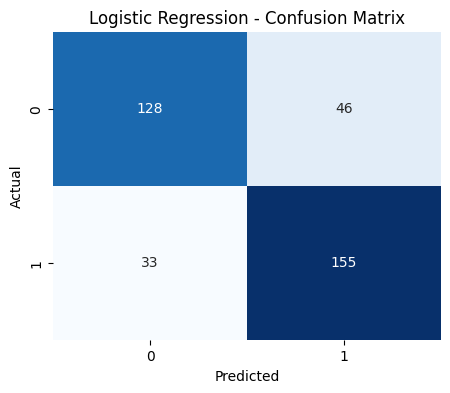


===== Random Forest (tuned) =====
Accuracy: 0.9751
ROC-AUC: 0.9982
Confusion Matrix:
 [[169   5]
 [  4 184]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97       174
           1       0.97      0.98      0.98       188

    accuracy                           0.98       362
   macro avg       0.98      0.97      0.98       362
weighted avg       0.98      0.98      0.98       362



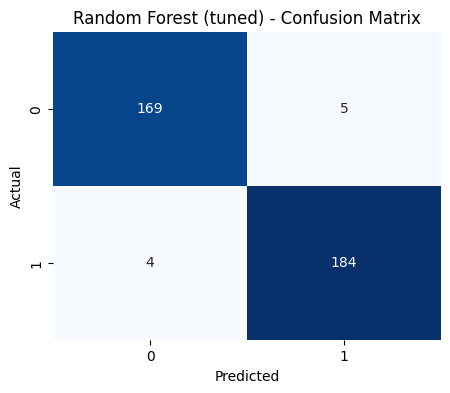


===== XGBoost (tuned) =====
Accuracy: 0.9613
ROC-AUC: 0.9973
Confusion Matrix:
 [[165   9]
 [  5 183]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       174
           1       0.95      0.97      0.96       188

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362



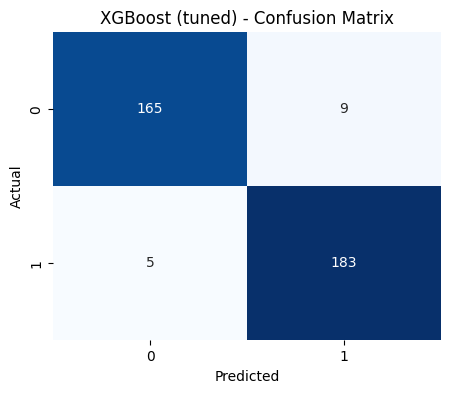

In [ ]:
# Evaluate classical models & show confusion matrices
models = {
    'Logistic Regression': lr,
    'Random Forest (tuned)': best_rf,
    'XGBoost (tuned)': best_xgb
}

results = {}
plt.style.use('default')


for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        # fallback (SVM if used) - but our models have predict_proba
        y_prob = model.decision_function(X_test)
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {'Accuracy': acc, 'ROC_AUC': auc}

    print(f"\n===== {name} =====")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC: {auc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Epoch 1/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6620 - loss: 0.6489 - val_accuracy: 0.7759 - val_loss: 0.5543
Epoch 2/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7178 - loss: 0.5843 - val_accuracy: 0.7655 - val_loss: 0.5175
Epoch 3/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7233 - loss: 0.5511 - val_accuracy: 0.7828 - val_loss: 0.4714
Epoch 4/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.5080 - val_accuracy: 0.7724 - val_loss: 0.4620
Epoch 5/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7612 - loss: 0.5048 - val_accuracy: 0.7828 - val_loss: 0.4480
Epoch 6/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7527 - loss: 0.5313 - val_accuracy: 0.8276 - val_loss: 0.4233
Epoch 7/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7778 - loss: 0.4763 - val_accuracy: 0.8138 - val_loss: 0.4386
Epoch 8/100
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7557 - loss: 0.4827 - val_accuracy: 0.8345 - v

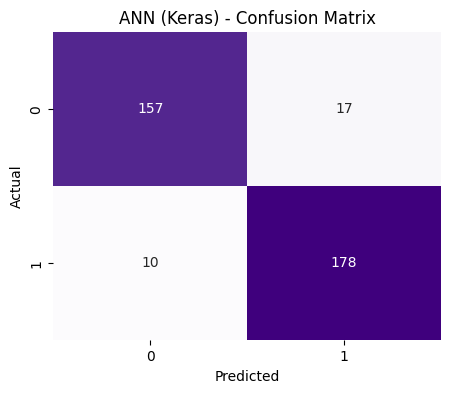

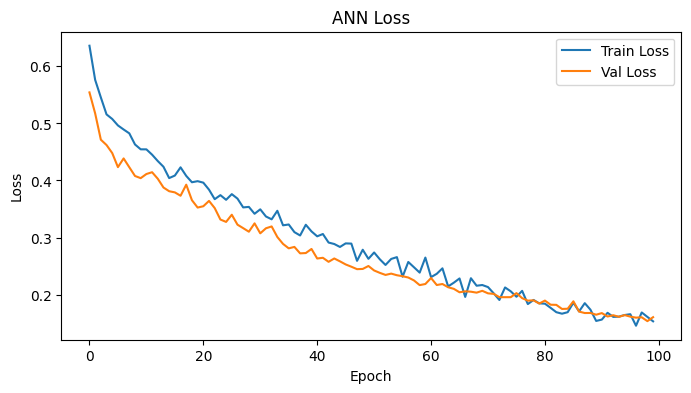

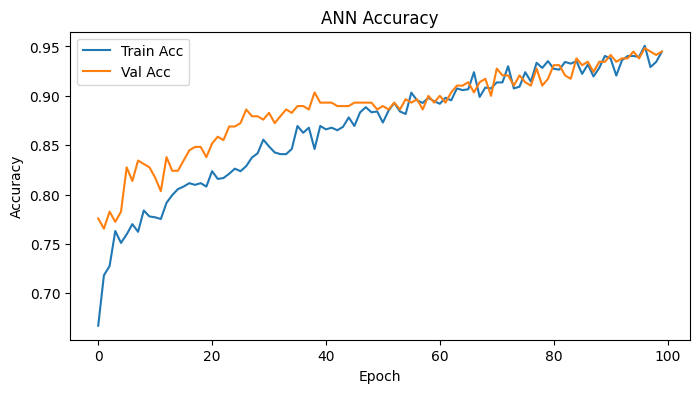

In [ ]:
# Improved ANN (Keras)
input_dim = X_train.shape[1]
ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer=Adam(learning_rate=5e-4), loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ann.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=1)

# Evaluate ANN
y_prob_ann = ann.predict(X_test).ravel()
y_pred_ann = (y_prob_ann > 0.5).astype(int)
acc_ann = accuracy_score(y_test, y_pred_ann)
auc_ann = roc_auc_score(y_test, y_prob_ann)
results['ANN (Keras)'] = {'Accuracy': acc_ann, 'ROC_AUC': auc_ann}

print("\n===== ANN (Keras) =====")
print(f"Accuracy: {acc_ann:.4f}")
print(f"ROC-AUC: {auc_ann:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ann))
cm_ann = confusion_matrix(y_test, y_pred_ann)
print("Confusion Matrix:\n", cm_ann)

plt.figure(figsize=(5,4))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title('ANN (Keras) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot training curves
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('ANN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



===== Ensemble (RF+XGB+LR+ANN) =====
Accuracy: 0.9613
ROC-AUC: 0.9959
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       174
           1       0.95      0.98      0.96       188

    accuracy                           0.96       362
   macro avg       0.96      0.96      0.96       362
weighted avg       0.96      0.96      0.96       362

Confusion Matrix:
 [[164  10]
 [  4 184]]


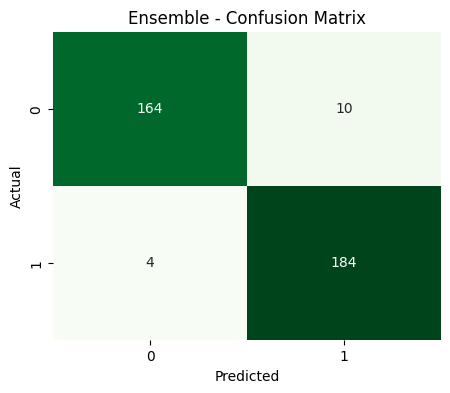

In [ ]:
# Ensemble: soft average of probs (RF, XGB, LR, ANN)
rf_prob = best_rf.predict_proba(X_test)[:, 1]
xgb_prob = best_xgb.predict_proba(X_test)[:, 1]
lr_prob = lr.predict_proba(X_test)[:, 1]
# ann_prob already computed as y_prob_ann
ensemble_prob = (rf_prob + xgb_prob + lr_prob + y_prob_ann) / 4.0
ensemble_pred = (ensemble_prob >= 0.5).astype(int)

acc_ens = accuracy_score(y_test, ensemble_pred)
auc_ens = roc_auc_score(y_test, ensemble_prob)
results['Ensemble (RF+XGB+LR+ANN)'] = {'Accuracy': acc_ens, 'ROC_AUC': auc_ens}

print("\n===== Ensemble (RF+XGB+LR+ANN) =====")
print(f"Accuracy: {acc_ens:.4f}")
print(f"ROC-AUC: {auc_ens:.4f}")
print("Classification Report:\n", classification_report(y_test, ensemble_pred))
cm_ens = confusion_matrix(y_test, ensemble_pred)
print("Confusion Matrix:\n", cm_ens)

plt.figure(figsize=(5,4))
sns.heatmap(cm_ens, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Ensemble - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# -----------------------
# Final results table
# -----------------------
results_df = pd.DataFrame(results).T.sort_values(by='ROC_AUC', ascending=False)
print("\nModel Performance Summary:\n")
print(results_df)


Model Performance Summary:

                          Accuracy   ROC_AUC
Random Forest (tuned)     0.975138  0.998196
XGBoost (tuned)           0.961326  0.997310
Ensemble (RF+XGB+LR+ANN)  0.961326  0.995934
ANN (Keras)               0.925414  0.977011
Logistic Regression       0.781768  0.845439


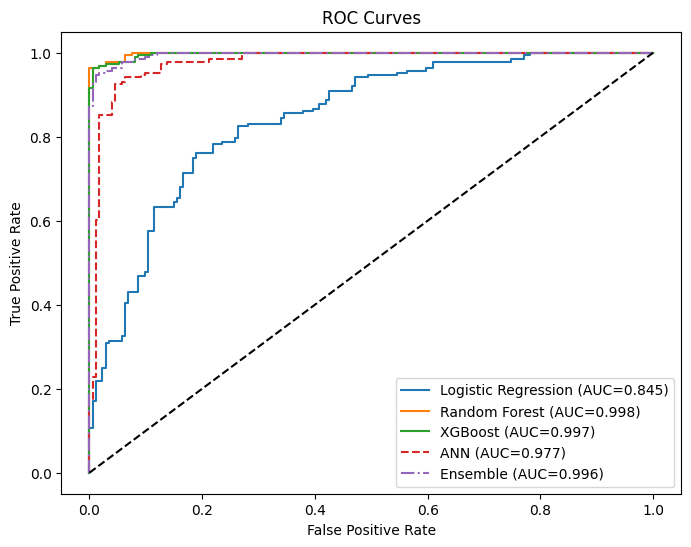

In [ ]:

# ROC curves for all models (incl. ANN and ensemble)
plt.figure(figsize=(8,6))
for name, model in [('Logistic Regression', lr), ('Random Forest', best_rf), ('XGBoost', best_xgb)]:
    prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc_score(y_test, prob):.3f})')

# ANN ROC
fpr_ann, tpr_ann, _ = roc_curve(y_test, y_prob_ann)
plt.plot(fpr_ann, tpr_ann, linestyle='--', label=f'ANN (AUC={auc_ann:.3f})')

# Ensemble ROC
fpr_e, tpr_e, _ = roc_curve(y_test, ensemble_prob)
plt.plot(fpr_e, tpr_e, linestyle='-.', label=f'Ensemble (AUC={auc_ens:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


Top feature importances (Random Forest):
     feature  importance
5      thal    0.168697
0        cp    0.145444
2  thalachh    0.138627
4       age    0.117185
8   oldpeak    0.110039
9        ca    0.105939
1     slope    0.088126
6       sex    0.042375
3   restecg    0.041808
7     exang    0.041759


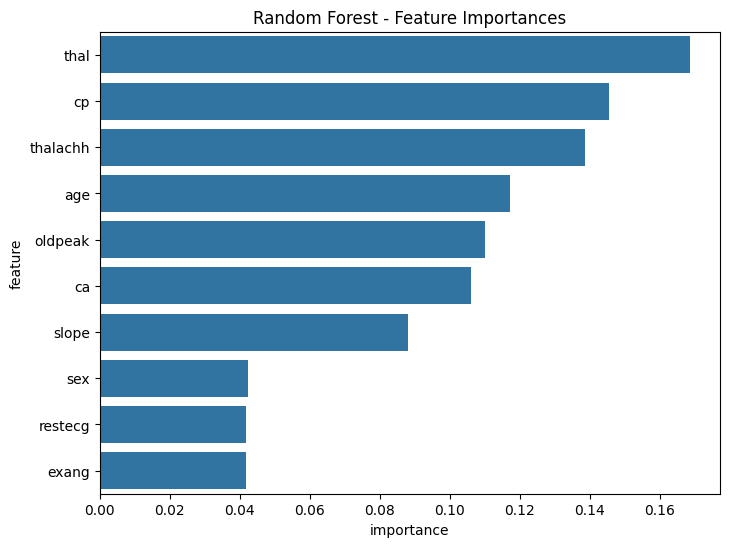


Cross-validated RF AUC scores: [0.99842565 0.99760027 0.997371   0.99798319 0.99657324]
Mean CV AUC: 0.997590669856951


In [ ]:

# Feature importances from best RF
try:
    importances = best_rf.feature_importances_
    feat_names = X.columns
    feat_imp_df = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values(by='importance', ascending=False)
    print("\nTop feature importances (Random Forest):\n", feat_imp_df.head(10))

    plt.figure(figsize=(8,6))
    sns.barplot(x='importance', y='feature', data=feat_imp_df.head(15))
    plt.title('Random Forest - Feature Importances')
    plt.show()
except Exception as e:
    print("Could not compute RF feature importances:", e)

# Optional: Cross-validated AUC for best RF
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores = cross_val_score(best_rf, X, y, cv=skf, scoring='roc_auc', n_jobs=-1)
print("\nCross-validated RF AUC scores:", cv_scores)
print("Mean CV AUC:", np.mean(cv_scores))

In [ ]:
# Print model summaries
print(best_rf)
print(best_xgb)
print(lr)


ann.summary()


RandomForestClassifier(bootstrap=False, max_depth=20, n_estimators=200,
                       random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)
LogisticRegression(max_iter=2000, random_state=42)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,333 (138.02 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,556 (92.02 KB)